In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import Dataset, random_split

# 2D

In [2]:
class ParabolaDataset(Dataset):
    def __init__(self, n_samples=1000, noise=0.0):
        self.n_samples = n_samples
        self.noise = noise
        self.x = torch.FloatTensor(np.random.uniform(-1,1, size=(n_samples)))
        self.y = torch.pow(self.x, 2) + torch.randn(n_samples) * noise

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

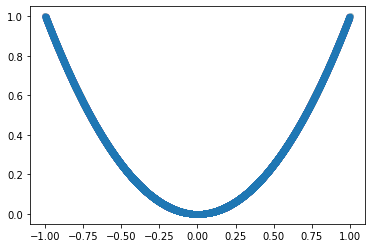

In [3]:
parabola = ParabolaDataset(n_samples=100000, noise=0.)
plt.scatter(parabola.x, parabola.y, alpha=0.01)

In [4]:
class Generator(nn.Module):
    def __init__(self, latent_space, hidden_dim, gen_dim=2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_space, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, gen_dim)) # x,y

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, hidden_dim, gen_dim=2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(gen_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,1), # real/fake
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)

In [5]:
latent_dim = 5
batch_size = 35
hidden_dim = 50
epochs = 10
lr = 3e-4

train_loader = DataLoader(parabola, batch_size=batch_size, shuffle=True)

netG = Generator(latent_dim, hidden_dim=hidden_dim)
netD = Discriminator(hidden_dim=hidden_dim)

loss_func = nn.BCELoss()

optD = torch.optim.Adam(netD.parameters(), lr=lr)
optG = torch.optim.Adam(netG.parameters(), lr=lr)

In [13]:
def train(netD, netG, train_loader, epochs, loss_func, optD, optG, noise_func=torch.randn):
    loss_D_list, loss_G_list = [], []
    step = 0
    for epoch in range(1, epochs+1):
        loss_D_epoch, loss_G_epoch = 0, 0
        for i, (x, y) in enumerate(train_loader):
            inputs = torch.vstack([x,y]).permute(1,0)
            inputs = inputs

            valid = torch.ones(inputs.size(0))

            fake = torch.zeros(inputs.size(0))
            
            # dicriminator
            netD.zero_grad()
            z = noise_func(inputs.size(0), latent_dim)

            logits_real = netD(inputs)
            loss_D_real = loss_func(logits_real.squeeze(), valid)

            fake_inputs = netG(z)
            logits_fake = netD(fake_inputs.detach())
            loss_D_fake = loss_func(logits_fake.squeeze(), fake)

            loss_D = (loss_D_fake + loss_D_real)/2
            loss_D.backward()
            optD.step()

            # generator
            netG.zero_grad()

            fake_inputs = netG(z)
            logits_fake = netD(fake_inputs)
            loss_G = loss_func(logits_fake.squeeze(), valid)
            loss_G.backward()
            optG.step()

            loss_D_epoch += loss_D.item()
            loss_G_epoch += loss_G.item()
            print(f"\rEpoch {epoch}/{epochs} - {i}/{len(train_loader)} - loss_D: {loss_D.item():.4f} - loss_G: {loss_G.item():.4f}", end="")
            
#             if step % 500 == 0:
#                 writer.add_scalar("LossD", loss_D, step)
#                 writer.add_scalar("LossG", loss_G, step)
#                 writer.add_figure('Current state', gen_plot(netG), step)
#                 writer.flush()
#             step+=1
#     writer.close()


In [14]:
train(netD, netG, train_loader, epochs, loss_func, optD, optG, noise_func=torch.randn)

Epoch 10/10 - 2857/2858 - loss_D: 0.6912 - loss_G: 0.6907

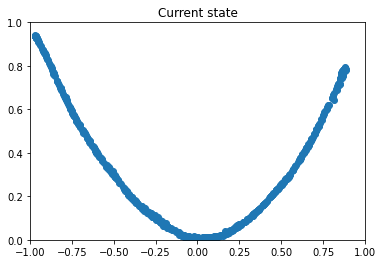

In [15]:
def gen_plot(netG, xlim=1, ylim_0=0, ylim_1=1):
    """Create a pyplot plot and save to buffer."""
    z = torch.randn(700, 5)
    with torch.no_grad():
        inputs = netG(z).cpu()
    fig = plt.figure()
    plt.scatter(inputs[:,0], inputs[:,1])
    plt.title("Current state")
    plt.xlim(-xlim,xlim)
    plt.ylim(ylim_0,ylim_1)
    return fig


with torch.no_grad():
    gen_plot(netG)

In [72]:
z = torch.randn(700, 5)

<AxesSubplot:>

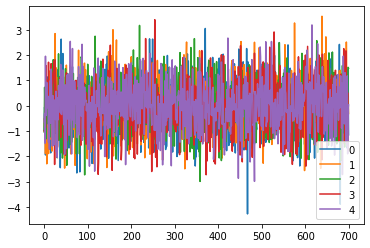

In [76]:
pd.DataFrame(z).plot()

# 3D

In [82]:
# %matplotlib qt

In [84]:
%matplotlib inline

In [85]:
class EllipticParaboloidDataset(Dataset):
    def __init__(self, n_samples=1000, noise=0.0):
        self.n_samples = n_samples
        self.noise = noise
        self.x = torch.FloatTensor(np.random.uniform(-1,1, size=(n_samples)))
        self.y = torch.FloatTensor(np.random.uniform(-1,1, size=(n_samples))) + torch.randn(n_samples) * noise
        self.z = self.x**2+self.y**2 + torch.randn(n_samples) * noise

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx], self.z[idx]

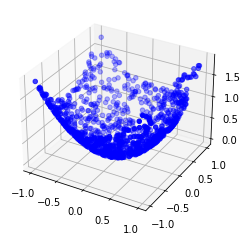

In [86]:
paraboloid = EllipticParaboloidDataset(n_samples=1000, noise=0.)
ax = plt.axes(projection='3d')
ax.scatter3D(paraboloid.x, paraboloid.y, paraboloid.z, c='blue')

paraboloid = EllipticParaboloidDataset(n_samples=100000, noise=0.)

In [95]:
latent_dim = 5
batch_size = 35
hidden_dim = 50
epochs = 50
lr = 3e-4

train_loader = DataLoader(paraboloid, batch_size=batch_size, shuffle=True)

netG = Generator(latent_dim, hidden_dim=hidden_dim, gen_dim=3)
netD = Discriminator(hidden_dim=hidden_dim, gen_dim=3)

loss_func = nn.BCELoss()

optD = torch.optim.Adam(netD.parameters(), lr=lr)
optG = torch.optim.Adam(netG.parameters(), lr=lr)

In [96]:
def train(netD, netG, train_loader, epochs, loss_func, optD, optG, noise_func=torch.randn):
    loss_D_list, loss_G_list = [], []
    step = 0
    for epoch in range(1, epochs+1):
        loss_D_epoch, loss_G_epoch = 0, 0
        for i, (x, y, z) in enumerate(train_loader):
            inputs = torch.vstack([x, y, z]).permute(1,0)
            inputs = inputs

            valid = torch.ones(inputs.size(0))

            fake = torch.zeros(inputs.size(0))
            
            # dicriminator
            netD.zero_grad()
            z = noise_func(inputs.size(0), latent_dim)

            logits_real = netD(inputs)
            loss_D_real = loss_func(logits_real.squeeze(), valid)

            fake_inputs = netG(z)
            logits_fake = netD(fake_inputs.detach())
            loss_D_fake = loss_func(logits_fake.squeeze(), fake)

            loss_D = (loss_D_fake + loss_D_real)/2
            loss_D.backward()
            optD.step()

            # generator
            netG.zero_grad()

            fake_inputs = netG(z)
            logits_fake = netD(fake_inputs)
            loss_G = loss_func(logits_fake.squeeze(), valid)
            loss_G.backward()
            optG.step()

            loss_D_epoch += loss_D.item()
            loss_G_epoch += loss_G.item()
            print(f"\rEpoch {epoch}/{epochs} - {i}/{len(train_loader)} - loss_D: {loss_D.item():.4f} - loss_G: {loss_G.item():.4f}", end="")
            
#             if step % 500 == 0:
#                 writer.add_scalar("LossD", loss_D, step)
#                 writer.add_scalar("LossG", loss_G, step)
#                 writer.add_figure('Current state', gen_plot(netG), step)
#                 writer.flush()
#             step+=1
#     writer.close()

In [97]:
train(netD, netG, train_loader, epochs, loss_func, optD, optG, noise_func=torch.randn)

Epoch 50/50 - 2857/2858 - loss_D: 0.6920 - loss_G: 0.6957

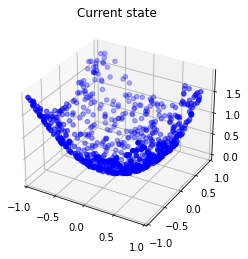

In [98]:
def gen_plot(netG, xlim=1, ylim_0=0, ylim_1=1):
    """Create a pyplot plot and save to buffer."""
    z = torch.randn(700, 5)
    with torch.no_grad():
        inputs = netG(z).cpu()
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(inputs[:,0], inputs[:,1], inputs[:,2], c='blue')
    plt.title("Current state")
    plt.xlim(-xlim,xlim)
    plt.ylim(-ylim_1,ylim_1)
    return fig


with torch.no_grad():
    gen_plot(netG)